In [14]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import warnings
import pandas as pd
from astropy.wcs import WCS
warnings.filterwarnings("ignore")
from numpy.fft import rfft2, irfft2, ifftshift
from scipy.signal import fftconvolve
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from astropy.nddata import Cutout2D
import gc
from astropy.wcs.utils import proj_plane_pixel_scales
import astropy.units as u
import os
from multiprocessing import get_context

In [15]:
mer_catalog = {'53.0_-28.0': 'EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits',
               '58.9_-48.6': 'EUC_MER_FINAL-CAT_TILE102021011-3A8DD3_20241020T112743.867901Z_00.00.fits'}

In [16]:
# Set location of the data
location = '/net/vdesk/data2/deklerk/GAAP_data'

# Set the field
field = '58.9_-48.6'

In [17]:
with fits.open(f'/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/{field}/{mer_catalog[field]}', memmap=True) as hdul:
    hdul.info()
    cat = Table(hdul[1].data)

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/58.9_-48.6/EUC_MER_FINAL-CAT_TILE102021011-3A8DD3_20241020T112743.867901Z_00.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EUC_MER__FINAL_CATALOG    1 BinTableHDU   1460   111511R x 469C   [K, D, D, D, D, K, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E

In [18]:
fluxes = pd.read_csv(f'/net/vdesk/data2/deklerk/GAAP_data/{field}/fluxes.csv', index_col=0)

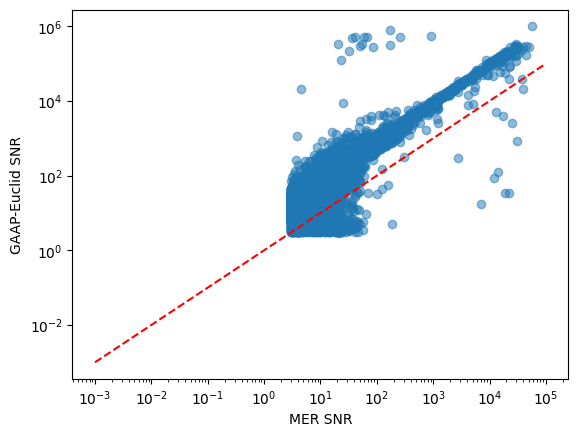

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.9879219388362223
Average SNR improvement factor (GAAP-Euclid / MER): 8.20640520075834


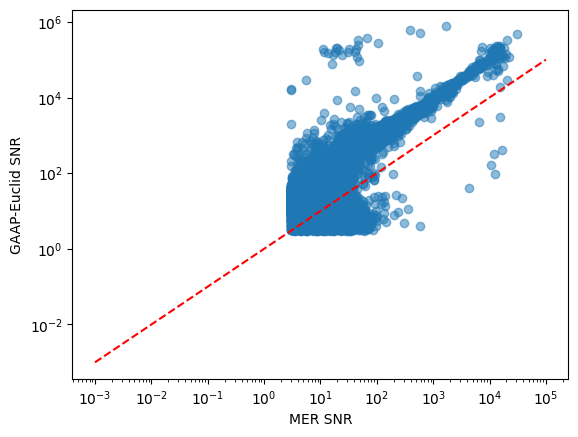

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.9754923261432569
Average SNR improvement factor (GAAP-Euclid / MER): 9.420239980342318


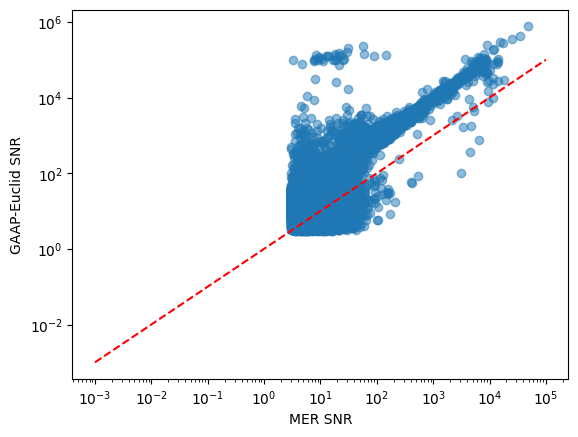

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.9638581066023784
Average SNR improvement factor (GAAP-Euclid / MER): 12.321598581209471


In [19]:
for filter in ['G', 'R', 'I']:
    snr_meer = cat[f'FLUX_{filter}_EXT_DECAM_4FWHM_APER'] / cat[f'FLUXERR_{filter}_EXT_DECAM_4FWHM_APER']
    snr_gaap_euclid = fluxes[f'flux_DES-{filter}']/fluxes[f'flux_DES-{filter}_sigma']
    cutoff_snr = 3
    mask = (snr_meer > cutoff_snr) & (snr_gaap_euclid > cutoff_snr) & (np.isfinite(snr_gaap_euclid)) & (np.isfinite(snr_meer))
    plt.scatter(snr_meer[mask],
                snr_gaap_euclid[mask],
                alpha=0.5)
    plt.plot([1e-3, 1e5], [1e-3, 1e5], 'r--')
    plt.xlabel('MER SNR')
    plt.ylabel('GAAP-Euclid SNR')
    plt.loglog()
    plt.show()
    print("Percent of sources where GAAP-Euclid SNR > MER SNR:", np.nansum(snr_gaap_euclid[mask] > snr_meer[mask])/ np.sum(~np.isnan(snr_gaap_euclid[mask])))
    print("Average SNR improvement factor (GAAP-Euclid / MER):", np.nanmean(snr_gaap_euclid[mask] / snr_meer[mask]))

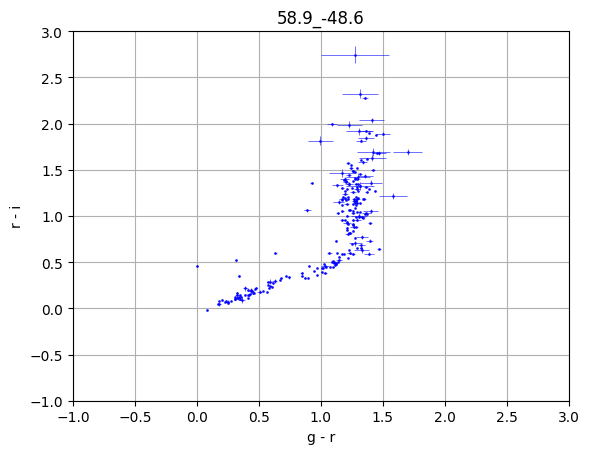

In [31]:
filter_1 = 'flux_g'   # e.g., master_table column name
filter_2 = 'flux_r'
filter_3 = 'flux_r'
filter_4 = 'flux_i'

plot_error = True

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Compute colors from master_table fluxes
    x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
    y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
        (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
        (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
    )

    # Select star based on MER catalog
    mask = cat['POINT_LIKE_PROB'] > 0.9
    gaap_error = xerr**2 + yerr**2
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
    )

    plt.title(f'{field}')
    plt.xlabel(f'{filter_1[5:]} - {filter_2[5:]}')
    plt.ylabel(f'{filter_3[5:]} - {filter_4[5:]}')
    plt.xlim(-1, 3)
    plt.ylim(-1, 3)
    plt.show()

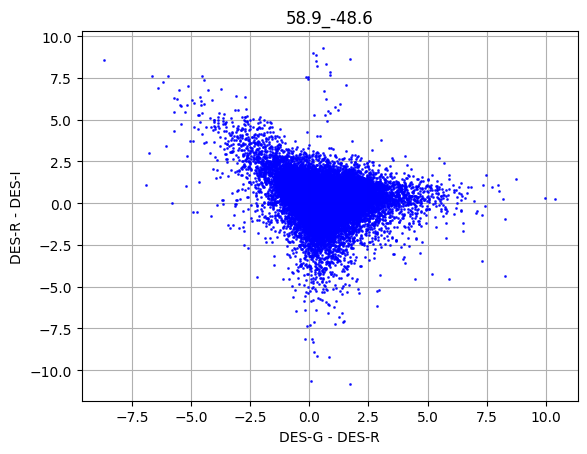

In [41]:
filter_1 = 'flux_DES-G'   # e.g., master_table column name
filter_2 = 'flux_DES-R'
filter_3 = 'flux_DES-R'
filter_4 = 'flux_DES-I'

plot_error = False
max_error = 0.1
with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Compute colors from master_table fluxes
    x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
    y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
        (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
        (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
    )

    gaap_error = xerr**2 + yerr**2
    # Select star based on MER catalog
    mask = cat['POINT_LIKE_PROB'] >= 0
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
    )

    plt.title(f'{field}')
    plt.xlabel(f'{filter_1[5:]} - {filter_2[5:]}')
    plt.ylabel(f'{filter_3[5:]} - {filter_4[5:]}')
    # plt.xlim(-1, 3)
    # plt.ylim(-1, 3)
    plt.show()